In [1]:
import rasterio
from rasterio.crs import CRS
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from tqdm import tqdm

# Generate tiles

We are going to use the Hansen et al. data found [here](https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/download.html). For actual products, this would likely be Planet data or some high resolution map that we would need for classification.

In [2]:
# box inputs are minx, miny, maxx, maxy
geometries = [box(-180 + i * 10, 
                  80 - (j + 1) * 10, 
                  -180 + (i + 1) * 10,
                  80 - (j) * 10) for i in range(36) for j in range(16)]

# Upper left corner
ul_corners = [(-180 + (i) * 10, 80 - (j) * 10) for i in range(36) for j in range(16)]

df_hansen_tiles = gpd.GeoDataFrame(geometry=geometries, crs=CRS.from_epsg(4326))

Let's see the tiles.

<AxesSubplot:>

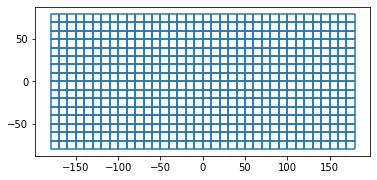

In [3]:
df_hansen_tiles.exterior.plot()

In [4]:
def url_generator(corner: tuple, 
                  layer: str ='last'):
    
    assert(layer in ['first', 'last', 'treecover2000'])
    
    base_url = 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8'
    lon, lat = corner
    if lon < 0:
        lon_str = f'{abs(lon):03d}W'
    else:
        lon_str = f'{abs(lon):03d}E'
    if lat >= 0:
        lat_str = f'{abs(lat):02d}N'
    else:
        lat_str = f'{abs(lat):02d}S'
    return f'{base_url}/Hansen_GFC-2020-v1.8_last_{lat_str}_{lon_str}.tif'


In [5]:
df_hansen_tiles['source_url'] = list(map(url_generator, ul_corners))
df_hansen_tiles['year'] = 2020
df_hansen_tiles['bucket'] = 'test-calval-hansen-mosaics-2020'
df_hansen_tiles['key'] = df_hansen_tiles.source_url.map(lambda x: x.split('/')[-1])

df_hansen_tiles.head()

,geometry,source_url,year,bucket,key
0,"POLYGON ((-170.00000 70.00000, -170.00000 80.0...",https://storage.googleapis.com/earthenginepart...,2020,test-calval-hansen-mosaics-2020,Hansen_GFC-2020-v1.8_last_80N_180W.tif
1,"POLYGON ((-170.00000 60.00000, -170.00000 70.0...",https://storage.googleapis.com/earthenginepart...,2020,test-calval-hansen-mosaics-2020,Hansen_GFC-2020-v1.8_last_70N_180W.tif
2,"POLYGON ((-170.00000 50.00000, -170.00000 60.0...",https://storage.googleapis.com/earthenginepart...,2020,test-calval-hansen-mosaics-2020,Hansen_GFC-2020-v1.8_last_60N_180W.tif
3,"POLYGON ((-170.00000 40.00000, -170.00000 50.0...",https://storage.googleapis.com/earthenginepart...,2020,test-calval-hansen-mosaics-2020,Hansen_GFC-2020-v1.8_last_50N_180W.tif
4,"POLYGON ((-170.00000 30.00000, -170.00000 40.0...",https://storage.googleapis.com/earthenginepart...,2020,test-calval-hansen-mosaics-2020,Hansen_GFC-2020-v1.8_last_40N_180W.tif


Let's read the bounds from the URLs and make sure they match.

In [6]:
url = df_hansen_tiles.source_url[0]
with rasterio.open(url) as ds:
    print(ds.bounds)
    print(url)

BoundingBox(left=-180.0001388888889, bottom=69.9998611111111, right=-169.99986111111113, top=80.00013888888888)
https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_80N_180W.tif


# Get Tiles over AOIs

In [7]:
aois = gpd.read_file('aois')
aois_geo = aois.geometry.unary_union

<AxesSubplot:>

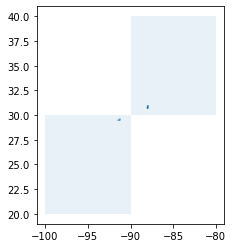

In [8]:
fig, ax = plt.subplots()

df_hansen_deltas = df_hansen_tiles[df_hansen_tiles.geometry.intersects(aois_geo)].reset_index(drop=True)

df_hansen_deltas.plot(ax = ax, alpha=.1)
aois.plot(ax=ax)

In [9]:
df_hansen_deltas

,geometry,source_url,year,bucket,key
0,"POLYGON ((-90.00000 20.00000, -90.00000 30.000...",https://storage.googleapis.com/earthenginepart...,2020,test-calval-hansen-mosaics-2020,Hansen_GFC-2020-v1.8_last_30N_100W.tif
1,"POLYGON ((-80.00000 30.00000, -80.00000 40.000...",https://storage.googleapis.com/earthenginepart...,2020,test-calval-hansen-mosaics-2020,Hansen_GFC-2020-v1.8_last_40N_090W.tif


# Upload Tile Index to s3

References from Stackoverflow:
+ [How to connect to s3](https://stackoverflow.com/a/40336919) - there are two ways
+ [Upload json to s3](https://stackoverflow.com/a/53004085)

In [10]:
geojson_bytes = bytes(df_hansen_deltas.to_json(drop_id=True).encode('UTF-8'))
geojson_bytes

b'{"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {"bucket": "test-calval-hansen-mosaics-2020", "key": "Hansen_GFC-2020-v1.8_last_30N_100W.tif", "source_url": "https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_30N_100W.tif", "year": 2020}, "geometry": {"type": "Polygon", "coordinates": [[[-90.0, 20.0], [-90.0, 30.0], [-100.0, 30.0], [-100.0, 20.0], [-90.0, 20.0]]]}}, {"type": "Feature", "properties": {"bucket": "test-calval-hansen-mosaics-2020", "key": "Hansen_GFC-2020-v1.8_last_40N_090W.tif", "source_url": "https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_40N_090W.tif", "year": 2020}, "geometry": {"type": "Polygon", "coordinates": [[[-80.0, 30.0], [-80.0, 40.0], [-90.0, 40.0], [-90.0, 30.0], [-80.0, 30.0]]]}}]}'

In [11]:
import boto3


session = boto3.session.Session(profile_name='saml-pub')

s3 = session.resource('s3')
s3object = s3.Object('calval-metadata', 'test-hansen-landsat.geojson')
s3object.put(Body=geojson_bytes)

{'ResponseMetadata': {'RequestId': '95NMB5QX62BZHHNK',
  'HostId': 'ModMs3o6Zaujt+cxt+bRPQGpa/1Hmp7JA5yqiLVtSZ6TsQRh5bNp8m6Zf6FXfAqQpOxAQSjlnS4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'ModMs3o6Zaujt+cxt+bRPQGpa/1Hmp7JA5yqiLVtSZ6TsQRh5bNp8m6Zf6FXfAqQpOxAQSjlnS4=',
   'x-amz-request-id': '95NMB5QX62BZHHNK',
   'date': 'Fri, 17 Dec 2021 00:20:58 GMT',
   'etag': '"52a1e9c4d64a172ee02c47da3bf63dea"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"52a1e9c4d64a172ee02c47da3bf63dea"'}

# Read Geojson on S3

Show existing buckets

In [12]:
buckets = list(s3.buckets.all())

Let's inspect the bucket contents.

In [13]:
metadata_bucket = s3.Bucket('calval-metadata')
list(metadata_bucket.objects.all())

[s3.ObjectSummary(bucket_name='calval-metadata', key='test-hansen-landsat.geojson')]

Read the actual dataframe.

In [14]:
obj = s3.Object('calval-metadata', 'test-hansen-landsat.geojson')
obj.get()

{'ResponseMetadata': {'RequestId': 'X9SF0EW0QY1D01CK',
  'HostId': 'PuULn3nkxSZr1o7LHyMfmENzAcnjJn2wAetJMsJwTeUX4L9fVSOcIR34zZyEkmWghJHpxbo2HSw=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'PuULn3nkxSZr1o7LHyMfmENzAcnjJn2wAetJMsJwTeUX4L9fVSOcIR34zZyEkmWghJHpxbo2HSw=',
   'x-amz-request-id': 'X9SF0EW0QY1D01CK',
   'date': 'Fri, 17 Dec 2021 00:20:59 GMT',
   'last-modified': 'Fri, 17 Dec 2021 00:20:58 GMT',
   'etag': '"52a1e9c4d64a172ee02c47da3bf63dea"',
   'accept-ranges': 'bytes',
   'content-type': 'binary/octet-stream',
   'server': 'AmazonS3',
   'content-length': '845'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2021, 12, 17, 0, 20, 58, tzinfo=tzutc()),
 'ContentLength': 845,
 'ETag': '"52a1e9c4d64a172ee02c47da3bf63dea"',
 'ContentType': 'binary/octet-stream',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x1d3cbf490>}

In [15]:
data = obj.get()['Body']
gpd.read_file(data)

,bucket,key,source_url,year,geometry
0,test-calval-hansen-mosaics-2020,Hansen_GFC-2020-v1.8_last_30N_100W.tif,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-90.00000 20.00000, -90.00000 30.000..."
1,test-calval-hansen-mosaics-2020,Hansen_GFC-2020-v1.8_last_40N_090W.tif,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-80.00000 30.00000, -80.00000 40.000..."


# Upload to Mosaics to s3 (this takes a *long* time)

The buckets have to be unique globally - interesting that this is harder than it seems and will throw an [error](https://stackoverflow.com/q/57146311) like this.

In [16]:
bucket_name = df_hansen_deltas.bucket[0]
if bucket_name not in [b.name for b in buckets]:
    s3.Bucket(bucket_name).create(CreateBucketConfiguration={'LocationConstraint': 'us-west-2'})

In [18]:
records = df_hansen_deltas.to_dict('records')

In [19]:
record = records[0]

In [ ]:
import requests

r = requests.get(record['source_url'], stream=True)


bucket_name = record['bucket']
key = record['key']

bucket = s3.Bucket(bucket_name)
bucket.upload_fileobj(r.raw, key)

Source of the function below: https://stackoverflow.com/questions/14346065/upload-image-available-at-public-url-to-s3-using-boto

In [ ]:
def upload_one(record):
    r = requests.get(record['source_url'], stream=True)

    bucket_name = record['bucket']
    key = record['key']

    bucket = s3.Bucket(bucket_name)
    response = bucket.upload_fileobj(r.raw, key)
    
    return response

In [ ]:
list(map(upload_one, tqdm(records)))

# Notes

+ S3 objects can be overwritten without problem. However, buckets cannot. So you cannot create a bucket that already exists, but you can easily overwrite an existing object

# Appendix

I initially used rasterio, but it was much slower. Keeping it here for reference. Probably because the memory file writing was unecessary.

References:

+ [rasterio mem files with a post](https://rasterio.readthedocs.io/en/latest/topics/memory-files.html#reading-memoryfiles)
+ [write s3 using rasterio](https://github.com/rasterio/rasterio/issues/1159#issuecomment-532027616)

In [ ]:
from rasterio.io import MemoryFile

def upload_one_slow(record):
    with rasterio.open(record['source_url']) as ds:
        src_profile = ds.profile
        src_array = ds.read()
    with MemoryFile() as memfile:
        with memfile.open(**src_profile) as dataset:
            dataset.write(src_array)

        s3ob = s3.Object(record['bucket'], record['key'])
        s3ob.put(Body=memfile)